In [10]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import cv2
import glob
import time
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Training the SVM 

###### Spatial binning

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    spatial_features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return spatial_features

##### Color histogram

In [3]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

##### HOG

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

##### Feature extraction

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [21]:

# Read in car and non-car images
cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')

# Hyper parameters that needs tuning
spatial = 16
histbin = 28
orient = 12 
pix_per_cell = 8
cell_per_block = 4
hog_channel = 1
cspace = 'HSV'

car_features = extract_features(cars, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

pickle.dump(X_train, open("X_train.p", "wb"))
pickle.dump(X_test, open("X_test.p", "wb"))
pickle.dump(y_train, open("y_train.p", "wb"))
pickle.dump(y_test, open("y_test.p", "wb"))
pickle.dump(X_scaler, open("X_scaler.p", "wb"))

print('Using spatial binning of:',spatial, 'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))


Using spatial binning of: 16 and 28 histogram bins
Feature vector length: 5652


In [22]:
# Use a linear SVC 
clf = LinearSVC()

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
pickle.dump(clf, open("clf.p", "wb"))
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My classifier predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels:    ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with clf')

28.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9642
My classifier predicts:  [1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
For these 10 labels:     [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
0.0 Seconds to predict 10 labels with clf


In [239]:
def get_features(image, cspace='HSV', spatial_size=(16, 16),
                        hist_bins=28, hist_range=(0, 256),
                        orient=12, pix_per_cell=8, cell_per_block=4, hog_channel=1):
    # Resize the image
#     print("image -", image.shape)
    image = cv2.resize(image,(64,64))
    # change to png format as the training was done on png images
    image = image.astype(np.float32)/255
    # Create a list to append feature vectors to
    features = []
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
        
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
      
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
    # Append the new feature vector to the features list
    features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    
    features = np.array(features).astype(np.float64)
#     print(features.shape)
#     features = features.reshape(-1,1)
#     print(features.shape)
#     features = X_scaler.transform(features)
    
    return features
    

The classifier is trained and saved in a pickle file named "clf.p", I have also saved the standardScalar object in "X_scaler.p"

now I can directly load my classifier from pickle file and use it in my pipeline.

## Designing the pipeline

In [242]:
class VideoProcessor():
    def __init__(self):
        self.frame = None
        
    def slide_window(self, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = self.frame.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = self.frame.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list

    def draw_boxes(self, bboxes, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        draw_img = np.copy(self.frame)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return draw_img
    
    def run_classifier(self, windows_all):
        windows_detected = []
        # Iterate through all windows
        for window in windows_all:
            crop = self.frame[window[0][1]:window[1][1], window[0][0]:window[1][0]]
            print(window[0][0],window[1][0], window[0][1],window[1][1])
            print(crop.shape)
            features = get_features(crop)
#             print(clf.predict(features))
#             if clf.predict(features) == 1:
#                 windows_detected.append(window)
        return windows_detected
        
    def pipeline(self, frame):
#         frame = preprocess(frame)
        self.frame = frame
        # this function returns the xy coordinates of all the windows
        windows_big = self.slide_window(x_start_stop=[140, None], y_start_stop=[350, 700], 
                                        xy_window=(140, 120), xy_overlap=(0.75, 0.75))
        windows_small = self.slide_window(x_start_stop=[100, 1200], y_start_stop=[400, 550], 
                                        xy_window=(105, 88), xy_overlap=(0.75, 0))
        windows_all = windows_big + windows_small 
#         print(windows_all)
        # this function returns the xy coordinates of windows in which vehicle is detected
        windows_detected = self.run_classifier(windows_all)
        self.frame = self.draw_boxes(windows_detected, color=(0, 255, 0), thick=2)
#         # this function returns the heatmap for the detected vehicle locations
#         heatmap = generate_heatmap(windows_detected)
#         # this function draws boxes around the detected vehicle
#         draw_boxes(heatmap)
        return self.frame

140 280 350 470
(120, 140, 3)
175 315 350 470
(120, 140, 3)
210 350 350 470
(120, 140, 3)
245 385 350 470
(120, 140, 3)
280 420 350 470
(120, 140, 3)
315 455 350 470
(120, 140, 3)
350 490 350 470
(120, 140, 3)
385 525 350 470
(120, 140, 3)
420 560 350 470
(120, 140, 3)
455 595 350 470
(120, 140, 3)
490 630 350 470
(120, 140, 3)
525 665 350 470
(120, 140, 3)
560 700 350 470
(120, 140, 3)
595 735 350 470
(120, 140, 3)
630 770 350 470
(120, 140, 3)
665 805 350 470
(120, 140, 3)
700 840 350 470
(120, 140, 3)
735 875 350 470
(120, 140, 3)
770 910 350 470
(120, 140, 3)
805 945 350 470
(120, 140, 3)
840 980 350 470
(120, 140, 3)
875 1015 350 470
(120, 140, 3)
910 1050 350 470
(120, 140, 3)
945 1085 350 470
(120, 140, 3)
980 1120 350 470
(120, 140, 3)
1015 1155 350 470
(120, 140, 3)
1050 1190 350 470
(120, 140, 3)
1085 1225 350 470
(120, 140, 3)
1120 1260 350 470
(120, 140, 3)
140 280 380 500
(120, 140, 3)
175 315 380 500
(120, 140, 3)
210 350 380 500
(120, 140, 3)
245 385 380 500
(120, 140, 3

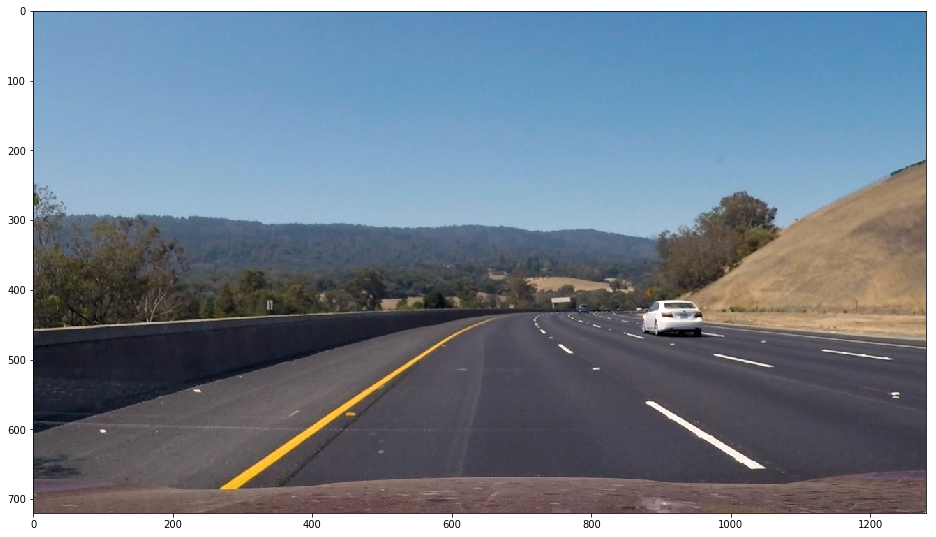

In [243]:
img = mpimg.imread('./test_images/test3.jpg')
video_processor = VideoProcessor()
img = video_processor.pipeline(img)
f, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(img)

In [186]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My classifier predicts: ', clf.predict(X_test[0:1]))
print('For these',n_predict, 'labels:    ', y_test[0:1])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with clf')

My classifier predicts:  [1.]
For these 10 labels:     [1.]
0.07291 Seconds to predict 10 labels with clf


In [189]:
print(X_test.shape)

(3552, 5652)
